# Imaging data products

Here we summarize the files available for imaging datasets, for example in the [v7]({{ site.baseurl }}/imaging/v7/) data release.

In [1]:
%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd

import astropy.io.fits as pyfits
import astropy.units as u

import sep

import grizli
from grizli import utils
print(f'grizli version: {grizli.__version__}')

BASE_URL = 'https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7/'

grizli version: 1.10.dev3+g341a999


# File extensions

Generally, for a given `root` and `filter` combination, the following files are available:

- `{root}-{filter}_drc_sci.fits.gz`: Science image
- `{root}-{filter}_drc_wht.fits.gz`: Inverse variance weight image (sky + readnoise)
- `{root}-{filter}_drc_exp.fits.gz`: Exposure-time map
- `{root}-{filter}_wcs.csv`: Table summarizing individual exposures that contribute to the mosaic

## Notes

1. All mosaics are created with the legacy `drizzlepac.adrizzle.do_driz` drizzle implementation that works interchangeably with JWST and HST.
    - `grizli` generates WCS for each exposure that follow the SIP-WCS convention and that match the newer `gwcs` JWST wcs at the level of 1e-4 pixels or better
1. All NIRCam LW, NIRISS (and HST) mosaics are created with 40 mas pixels
1. Most fields have 20 mas pixels for the NIRCam SW images that exacly subsample the LW grid 2x2.  
    - The very large `primer-cosmos` and `primer-uds` SW mosaics have 40 mas pixels
1. All `sci` mosaics have intensity units of `10 nJy / pix`, corresponding to an AB magnitude zeropoint 28.9.  This has the slightly desirable property that the image pixel values are not too different from unity.  
    - These are not the same as the surface brightness units of the JWST pipeline!
1. The `exp` exposure time images have units of seconds rounded to the nearest integer
    - Subsampled to 4x4 of the parent mosaic to keep the file sizes small
    - The `exp` images are created directly from the footprints of the constituent exposures and don't account for masked pixels *within* an exposure.

In [2]:
# Example
root = 'smacs0723-grizli-v7.0'

filter = 'f444w-clear'

In [3]:
# Open the files directly from the web

img = {}

print('# File shape')

for ext in ['sci','wht','exp']:
    _file = f'{root}-{filter}_drc_{ext}.fits.gz'
    img[ext] = pyfits.open(os.path.join(BASE_URL, _file))
    print(f'{_file} : {img[ext][0].data.shape}')

# File shape
smacs0723-grizli-v7.0-f444w-clear_drc_sci.fits.gz : (12000, 12000)
smacs0723-grizli-v7.0-f444w-clear_drc_wht.fits.gz : (12000, 12000)
smacs0723-grizli-v7.0-f444w-clear_drc_exp.fits.gz : (3000, 3000)


In [4]:
# Files have a single PrimaryHDU
img['sci'].info()

Filename: /Users/gbrammer/.astropy/cache/download/url/b0380671ce11dec1c5653485f66f705c/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      93   (12000, 12000)   float32   


## Primary `sci` header

In [5]:
img['sci'][0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                12000                                                  
NAXIS2  =                12000                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =               4591.5 / Pixel coordinate of reference point            
CRPIX2  =               6515.5 / Pixel coordinate of reference point            
CD1_1   = -1.1111111111111E-05 / Coordinate transformation matrix element       
CD2_2   =  1.1111111111111E-05 / Coordinate transformation matrix element       
CDELT1  =                  1.0 / [deg] Coordinate increment at reference point  
CDELT2  =                  1.0 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'             

In [6]:
# Images have units of 10 nJy / pix
for k in ('FILTER','PHOTFNU','PHOTPLAM','BUNIT'):
    print(f"{k:>8}: {img['sci'][0].header[k]}")

  FILTER: F444W
 PHOTFNU: 1e-08
PHOTPLAM: 44036.71097714713
   BUNIT: 10.0*nanoJansky


## Primary `exp` header

In [7]:
img['exp'][0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 3000                                                  
NAXIS2  =                 3000                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =             1147.875 / Pixel coordinate of reference point            
CRPIX2  =             1628.875 / Pixel coordinate of reference point            
CD1_1   = -4.4444444444444E-05 / Coordinate transformation matrix element       
CD2_2   =  4.4444444444444E-05 / Coordinate transformation matrix element       
CDELT1  =                  1.0 / [deg] Coordinate increment at reference point  
CDELT2  =                  1.0 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'             

## WCS log

The `wcs.csv` files contain the full SIP header of each exposure that contributes to the mosaic, along with some epoch information.

In [8]:
_file = f'{root}-{filter}_wcs.csv'
wcs = utils.read_catalog(os.path.join(BASE_URL, _file))
print(wcs.colnames)

['file', 'ext', 'exptime', 'wcsaxes', 'crpix1', 'crpix2', 'cd1_1', 'cd1_2', 'cd2_1', 'cd2_2', 'cdelt1', 'cdelt2', 'cunit1', 'cunit2', 'ctype1', 'ctype2', 'crval1', 'crval2', 'lonpole', 'latpole', 'wcsname', 'mjdref', 'date-beg', 'mjd-beg', 'date-avg', 'mjd-avg', 'date-end', 'mjd-end', 'xposure', 'telapse', 'obsgeo-x', 'obsgeo-y', 'obsgeo-z', 'radesys', 'velosys', 'a_order', 'a_0_2', 'a_0_3', 'a_0_4', 'a_0_5', 'a_1_1', 'a_1_2', 'a_1_3', 'a_1_4', 'a_2_0', 'a_2_1', 'a_2_2', 'a_2_3', 'a_3_0', 'a_3_1', 'a_3_2', 'a_4_0', 'a_4_1', 'a_5_0', 'b_order', 'b_0_2', 'b_0_3', 'b_0_4', 'b_0_5', 'b_1_1', 'b_1_2', 'b_1_3', 'b_1_4', 'b_2_0', 'b_2_1', 'b_2_2', 'b_2_3', 'b_3_0', 'b_3_1', 'b_3_2', 'b_4_0', 'b_4_1', 'b_5_0', 'naxis', 'naxis1', 'naxis2', 'sipcrpx1', 'sipcrpx2']


In [9]:
# First few lines
wcs['file','ext','exptime','mjd-avg','date-avg','crpix1','crpix2','crval1','crval2'][:4]

file,ext,exptime,mjd-avg,date-avg,crpix1,crpix2,crval1,crval2
str44,int64,float64,float64,str23,float64,float64,float64,float64
jw02736001001_02105_00001_nrcalong_rate.fits,1,837.468,59737.226108919,2022-06-07T05:25:35.811,1024.647,1024.66,110.68612332528,-73.481395298838
jw02736001001_02105_00001_nrcblong_rate.fits,1,837.468,59737.226105215,2022-06-07T05:25:35.491,1024.489,1024.662,110.8276309259,-73.453986741388
jw02736001001_02105_00002_nrcalong_rate.fits,1,837.468,59737.236795574,2022-06-07T05:40:59.138,1024.647,1024.66,110.68291892635,-73.47999884627
jw02736001001_02105_00002_nrcblong_rate.fits,1,837.468,59737.23679187,2022-06-07T05:40:58.818,1024.489,1024.662,110.82443032455,-73.452590822835


## Compare the WHT and EXP images

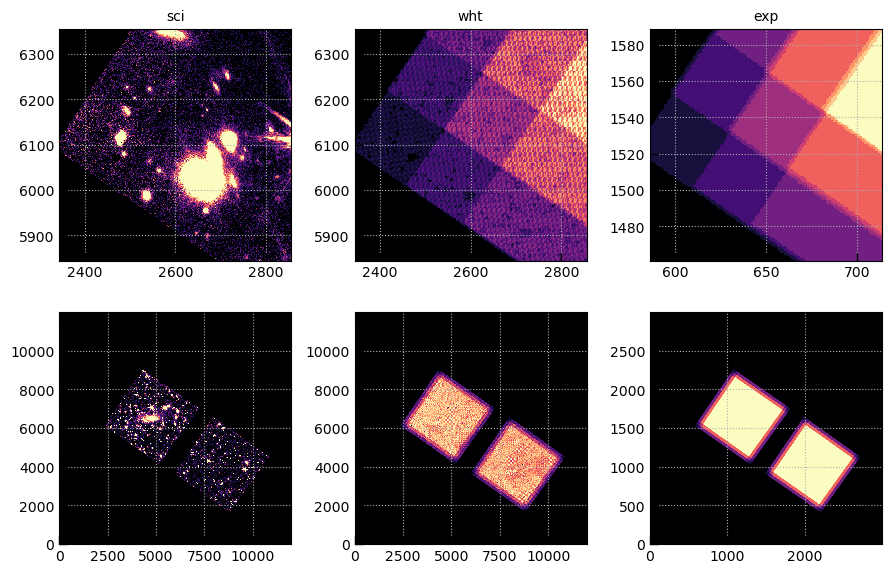

In [10]:

exts = ['sci','wht','exp']

fig, axes = plt.subplots(2,len(exts),figsize=(3*len(exts),6))

for j, ext in enumerate(exts):
    msk = img[ext][0].data != 0
    wmax = np.nanpercentile(img[ext][0].data[msk], 95)
    for i in [0,1]:
        axes[i][j].imshow(img[ext][0].data, vmin=0, vmax=wmax, origin='lower', cmap='magma')
        axes[i][j].grid()
        if i == 0:
            axes[i][j].set_title(ext)
        
xy = 2600, 6100, 256

for j, p in enumerate([0,0,1]):
    axes[0][j].set_xlim(*(xy[0] + np.array([-1,1])*xy[2])/4**p)
    axes[0][j].set_ylim(*(xy[1] + np.array([-1,1])*xy[2])/4**p)
    
fig.tight_layout(pad=1)

## Make a full variance image including the Poisson component from the sources themselves

The mosaics are created by weighting each input exposure by a factor like `1/wht = VAR_RNOISE + median(VAR_POISSON)` from the JWST exposure files.  The first term incorporates pixel-to-pixel variations resulting from pixels where some fraction of the reads may have been masked as saturated or affected by cosmic rays.  The second term effectively provides the noise from the sky background, but without including the Poisson term for individual sources.  

Certain applications like photometry or morphology fitting with `galfit` may require a variance / sigma image that includes the poisson term from the individual sources.  This can be generated from the `exp` maps as shown below.

In [11]:
# Grow the exposure map to the original frame
full_exp = np.zeros(img['sci'][0].data.shape, dtype=int)
full_exp[2::4,2::4] += img['exp'][0].data*1
full_exp = nd.maximum_filter(full_exp, 4)

img['Full exp'] = pyfits.HDUList([pyfits.PrimaryHDU(data=full_exp)])

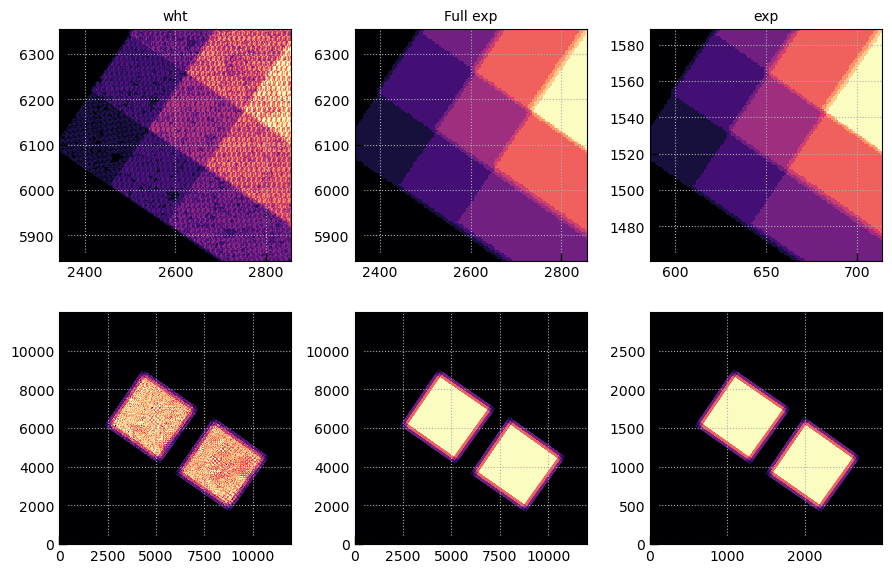

In [12]:
# Show the full exposure map
exts = ['wht','Full exp','exp']

fig, axes = plt.subplots(2,len(exts),figsize=(3*len(exts),6))

for j, ext in enumerate(exts):
    msk = img[ext][0].data != 0
    wmax = np.nanpercentile(img[ext][0].data[msk], 95)
    for i in [0,1]:
        axes[i][j].imshow(img[ext][0].data, vmin=0, vmax=wmax, origin='lower', cmap='magma')
        axes[i][j].grid()
        if i == 0:
            axes[i][j].set_title(ext)
        
xy = 2600, 6100, 256

for j, p in enumerate([0,0,1]):
    axes[0][j].set_xlim(*(xy[0] + np.array([-1,1])*xy[2])/4**p)
    axes[0][j].set_ylim(*(xy[1] + np.array([-1,1])*xy[2])/4**p)
    
fig.tight_layout(pad=1)

### Effective "gain"

To convert the Poisson variance associated with the `sci` image, write down the multiplicative factors that had been applied to the original count-rate data in the pipeline `rate` files.  `PHOTMJSR` is the original flux calibration to units of "MJy/sr" and `PHOTSCL` is any (small) additional photometric term that was included by `grizli`.  The `PHOTFNU / OPHOTFNU` term accounts for any final scaling of the output mosaic and the ratio of the original and mosaic pixel areas.

```python
# Scale factors
phot_scale = 1 / (PHOTMJSR * PHOTSCAL) * PHOTFNU / OPHOTFNU

# Effective gain e-/DN, including exposure time
effective_gain = phot_scale * exposure_time_map

# Variance in electrons = counts in electrons
var_poisson_elec = sci * effective_gain

# Variance in mosaic DN
var_poisson_dn = var_poisson_elec / effective_gain**2 = sci / effective_gain
```



In [13]:
header = img['exp'][0].header

# Multiplicative factors that have been applied since the original count-rate images
phot_scale = 1.

for k in ['PHOTMJSR','PHOTSCAL']:
    print(f'{k} {header[k]:.3f}')
    phot_scale /= header[k]

# Unit and pixel area scale factors
if 'OPHOTFNU' in header:
    phot_scale *= header['PHOTFNU'] / header['OPHOTFNU']

# "effective_gain" = electrons per DN of the mosaic
effective_gain = (phot_scale * full_exp)

# Poisson variance in mosaic DN
var_poisson_dn = np.maximum(img['sci'][0].data, 0) / effective_gain

# Original variance from the `wht` image = RNOISE + BACKGROUND
var_wht = 1/img['wht'][0].data

# New total variance
var_total = var_wht + var_poisson_dn
full_wht = 1 / var_total

# Null weights
full_wht[var_total <= 0] = 0

img['Full wht'] = pyfits.HDUList([pyfits.PrimaryHDU(data=full_wht, header=img['wht'][0].header)])

PHOTMJSR 0.393
PHOTSCAL 1.001


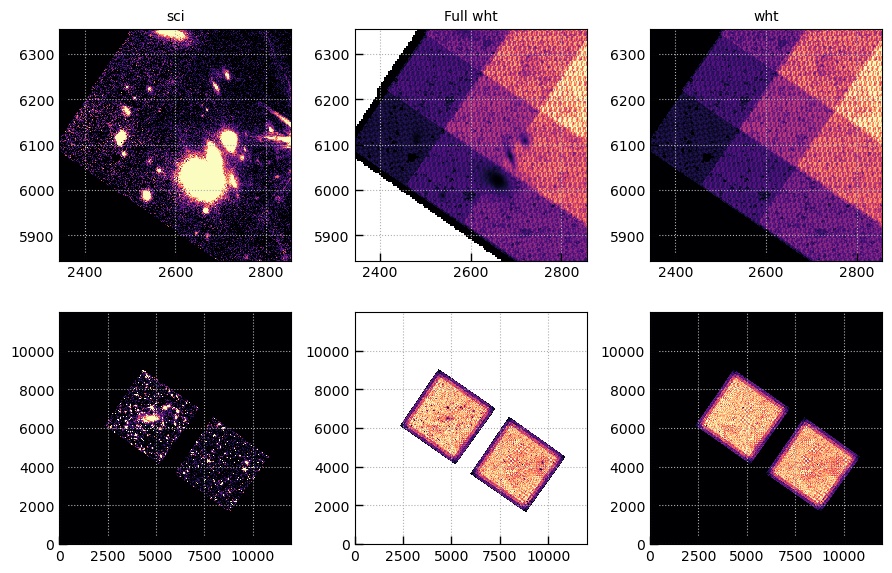

In [14]:
# Compare science and weight arrays, where you can now 
# "see" the sources in the Full weight array

exts = ['sci','Full wht','wht']

fig, axes = plt.subplots(2,len(exts),figsize=(3*len(exts),6))

for j, ext in enumerate(exts):
    msk = img[ext][0].data != 0
    wmax = np.nanpercentile(img[ext][0].data[msk], 95)
    for i in [0,1]:
        axes[i][j].imshow(img[ext][0].data, vmin=0, vmax=wmax, origin='lower', cmap='magma')
        axes[i][j].grid()
        if i == 0:
            axes[i][j].set_title(ext)
        
xy = 2600, 6100, 256

for j, p in enumerate([0,0,0]):
    axes[0][j].set_xlim(*(xy[0] + np.array([-1,1])*xy[2])/4**p)
    axes[0][j].set_ylim(*(xy[1] + np.array([-1,1])*xy[2])/4**p)
    
fig.tight_layout(pad=1)